In [1]:
import numpy as numpy
import pandas as pd

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import sklearn
from sklearn.utils import shuffle 
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [5]:
import re
import random
import gensim

In [6]:
from collections import Counter
import unicodedata as udata
import string

In [7]:
print(sklearn.__version__)
print(matplotlib.__version__)
print(numpy.__version__)
print(pd.__version__)
print(nltk.__version__)

0.20.4
2.2.4
1.17.2
0.24.2
3.4


In [8]:
df = pd.read_csv("TwitterSentimentAnalysis.csv", encoding='latin-1', header=None)

In [9]:
df = df.sample(frac=1).reset_index(drop=True)

In [10]:
df.columns = ["sentiment", "id", "date", "query", "user", "text"] 

In [11]:
df.columns

Index(['sentiment', 'id', 'date', 'query', 'user', 'text'], dtype='object')

In [12]:
df.isnull().sum()

sentiment    0
id           0
date         0
query        0
user         0
text         0
dtype: int64

In [13]:
df.duplicated().sum()

0

In [14]:
df.head(5)

,sentiment,id,date,query,user,text
0,0,2242505815,Fri Jun 19 12:16:30 PDT 2009,NO_QUERY,AngeLiiTaCullen,seeing Emilie and Rob kissing even just for a ...
1,4,2066083434,Sun Jun 07 09:51:25 PDT 2009,NO_QUERY,JussCallMeDaddy,juss got home. went 2 thunder valley last nigh...
2,0,1989211351,Mon Jun 01 00:43:45 PDT 2009,NO_QUERY,Mousethefiend,hooray! i finally get to go to bed! got to get...
3,4,1970277671,Sat May 30 03:11:30 PDT 2009,NO_QUERY,CiaraSlave,"@JPopMp3s I am, sis!"
4,0,1836399659,Mon May 18 07:55:44 PDT 2009,NO_QUERY,ifahmi,"@chibialfa waaah, udah jalan pulang Fa. Mandy ..."


In [15]:
df = df.drop(["id", "date", "query", "user"], axis = 1) 

In [16]:
df.head(5)

,sentiment,text
0,0,seeing Emilie and Rob kissing even just for a ...
1,4,juss got home. went 2 thunder valley last nigh...
2,0,hooray! i finally get to go to bed! got to get...
3,4,"@JPopMp3s I am, sis!"
4,0,"@chibialfa waaah, udah jalan pulang Fa. Mandy ..."


In [17]:
df.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [18]:
df['pre_clean_len'] = [len(t) for t in df.text]

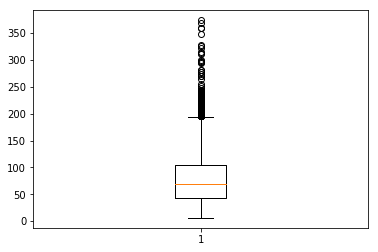

In [19]:
plt.boxplot(df.pre_clean_len)
plt.show()

In [20]:
df[df.pre_clean_len > 140].head(10) 

,sentiment,text,pre_clean_len
69,4,@mileycyrus this is silly but i had a dance tr...,145
94,4,@mia_kitty I think your right about the song w...,143
187,4,"Thx 4 the kind words, props, &amp; re-blips @...",142
201,4,"@selenagomez Hello Selena, I love &quot;Tell M...",143
235,4,"Guys, checkout ABC's #Wipeout! It's totally FU...",147
274,0,@Sealbroken Classic Nick Walker &amp; ome grea...,142
399,0,@FrankieTheSats @MollieOfficial @Rochellewisem...,141
486,4,@BlackWidowDiy ..... OMG it was ALOT of fun!!!...,145
500,0,@ayatoshirosan ...later to say that you just c...,146
510,4,@dee__cee im assuming &quot;lg traning&quot; i...,148


In [21]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'        # remove @ mentions from tweets
pat2 = r'https?://[^ ]+'        # remove URLs from tweets
combined_pat = r'|'.join((pat1, pat2)) #addition of pat1 and pat2
www_pat = r'www.[^ ]+'         # remove URLs from tweets
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",   # converting words like isn't to is not
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):  # define tweet_cleaner function to clean the tweets
    soup = BeautifulSoup(text, 'lxml')    # create beautiful soup object
    souped = soup.get_text()   # get only text from the tweets 
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")    # remove utf-8-sig code
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed) # calling combined_pat
    stripped = re.sub(www_pat, '', stripped) #remove URLs
    lower_case = stripped.lower()      # converting all into lower case
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case) # converting words like isn't to is not
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)       # will replace # by space
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1] # Word Punct Tokenize and only consider words whose length is greater than 1
    return (" ".join(words)).strip() # join the words

In [22]:
#Note that we have 1600000 instances. But processing so many instances will take a very very long time.
#Hence, restricting to rather 50000 instances.
limit=50000
import time; 
ms = time.time()
#nums = [0,400000,800000,1200000,1600000] # used for batch processing tweets
#nums = [0, 9999]
clean_tweet_texts = [] # initialize list
for i in range(0,limit): # batch process 1.6 million tweets 
    if i % 10000==0:
        print(i, time.time()-ms)
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))  # call tweet_cleaner function and pass parameter as all the tweets to clean the tweets and append cleaned tweets into clean_tweet_texts list

0 8.392333984375e-05
10000 3.4728739261627197
20000 6.913676023483276
30000 10.346076726913452
40000 13.782924890518188


In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jyotikhetan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [24]:
word_tokens = [] # initialize list for tokens
for word in clean_tweet_texts:  # for each word in clean_tweet_texts
    word_tokens.append(word_tokenize(word)) #tokenize word in clean_tweet_texts and append it to word_tokens list

In [25]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jyotikhetan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [29]:
df1 = [] # initialize list df1 to store words after lemmatization
from nltk.stem import WordNetLemmatizer # import WordNetLemmatizer from nltk.stem
lemmatizer = WordNetLemmatizer() # create an object of WordNetLemmatizer
for l in word_tokens: # for loop for every tokens in word_token
    b = [lemmatizer.lemmatize(q) for q in l] #for every tokens in word_token lemmatize word and giev it to b
    df1.append(b) #append b to list df1

In [30]:
clean_df1 =[] # initialize list clean_df1 to join word tokens after lemmatization
for c in df1:  # for loop for each list in df1
    a = " ".join(c) # join words in list with space in between and give it to a
    clean_df1.append(a) # append a to clean_df1

In [31]:
clean_df = pd.DataFrame(clean_df1,columns=['text']) # convert clean_tweet_texts into dataframe and name it as clean_df

In [32]:
clean_df['clean_len'] = [len(t) for t in clean_df.text] # Again make a new coloumn in the dataframe and name it as clean_len which 

In [33]:
clean_df[clean_df.clean_len > 140].head(10) # again check if any tweet is more than 140 characters

,text,clean_len


In [34]:
target2 = [] # initialize list
for i in range(0,limit): # batch process 1.6 million tweets 
    target2.append(df['sentiment'][i])
clean_df['target']=target2
df.head()

,sentiment,text,pre_clean_len
0,0,seeing Emilie and Rob kissing even just for a ...,90
1,4,juss got home. went 2 thunder valley last nigh...,120
2,0,hooray! i finally get to go to bed! got to get...,94
3,4,"@JPopMp3s I am, sis!",21
4,0,"@chibialfa waaah, udah jalan pulang Fa. Mandy ...",58


In [35]:
X = clean_df.text # get all the text in x variable
y = clean_df.target # get all the sentiments into y variable
print(X.shape) #print shape of x
print(y.shape) # print shape of y
from collections import Counter
print(set(y)) # equals to list(set(words))
print(Counter(y).values()) #

(50000,)
(50000,)
{0, 4}
dict_values([24901, 25099])


In [36]:
from sklearn.model_selection  import train_test_split #from sklearn.cross_validation import train_test_split to split the data into training and tesing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 1) # split the data into traing and testing set where ratio is 80:20

In [37]:
vect = TfidfVectorizer(analyzer = "word", ngram_range=(1,3))

In [38]:
vect.fit(X_train) 
X_train_dtm = vect.transform(X_train) 

In [39]:
X_test_dtm = vect.transform(X_test)

In [40]:
from sklearn.naive_bayes import MultinomialNB # import Multinomial Naive Bayes model from sklearn.naive_bayes
nb = MultinomialNB(alpha = 10) # get object of Multinomial naive bayes model with alpha parameter = 10

In [41]:
nb.fit(X_train_dtm, y_train)# fit our both training data tweets as well as their sentiments to the multinomial naive bayes model

MultinomialNB(alpha=10, class_prior=None, fit_prior=True)

In [42]:
from sklearn.model_selection import cross_val_score  # import cross_val_score from sklear.model_selection
accuracies = cross_val_score(estimator = nb, X = X_train_dtm, y = y_train, cv = 10) # do K- fold cross validation on our traing data and its sentimenst with 10 fold cross validation
accuracies.mean() # measure the mean accuray of 10 fold cross validation

0.7616001157828197

In [43]:
y_pred_nb = nb.predict(X_test_dtm) 

In [44]:
from sklearn import metrics # import metrics from sklearn
metrics.accuracy_score(y_test, y_pred_nb) 

0.7593

In [45]:
from sklearn.metrics import confusion_matrix # import confusion matrix from the sklearn.metrics
confusion_matrix(y_test, y_pred_nb)

array([[4202,  770],
       [1637, 3391]])

In [46]:
from sklearn.linear_model import LogisticRegression # import Logistic Regression model from sklearn.linear_model
logisticRegr = LogisticRegression(C = 1.1) # get object of logistic regression model with cost parameter = 1.1

In [47]:
logisticRegr.fit(X_train_dtm, y_train)# fit our both traing data tweets as well as its sentiments to the logistic regression model

/Users/jyotikhetan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [48]:
from sklearn.model_selection import cross_val_score # import cross_val_score from sklear.model_selection
accuracies = cross_val_score(estimator = logisticRegr, X = X_train_dtm, y = y_train, cv = 10) # do K- fold cross validation on our traing data and its sentimenst with 10 fold cross validation
accuracies.mean() # measure the mean accuray of 10 fold cross validation

/Users/jyotikhetan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7755001159171947

In [49]:
y_pred_lg = logisticRegr.predict(X_test_dtm)  # predict the sentiments of testing data tweets

In [50]:
from sklearn import metrics # import metrics from sklearn
metrics.accuracy_score(y_test, y_pred_lg) # measure the accuracy of our model on the testing data

0.7751

In [51]:
from sklearn.metrics import confusion_matrix # import confusion matrix from the sklearn.metrics
confusion_matrix(y_test, y_pred_lg) # plot the confusion matrix between our predicted sentiments and the original testing data sentiments

array([[4008,  964],
       [1285, 3743]])

In [52]:
from sklearn.svm import LinearSVC # import SVC model from sklearn.svm
svm_clf = LinearSVC(random_state=0) # get object of SVC model with random_state parameter = 0

In [53]:
svm_clf.fit(X_train_dtm, y_train)# fit our both traing data tweets as well as its sentiments to the SVC model

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

In [54]:
from sklearn.model_selection import cross_val_score  # import cross_val_score from sklear.model_selection
accuracies = cross_val_score(estimator = svm_clf, X = X_train_dtm, y = y_train, cv = 10)# do K- fold cross validation on our traing data and its sentimenst with 10 fold cross validation
accuracies.mean() # measure the mean accuray of 10 fold cross validation

0.7802751534859471

In [55]:
y_pred_svm = svm_clf.predict(X_test_dtm)  # predict the sentiments of testing data tweets

In [56]:
from sklearn import metrics  # import metrics from sklearn
metrics.accuracy_score(y_test, y_pred_svm)  # measure the accuracy of our model on the testing data

0.7789

In [57]:
from sklearn.metrics import confusion_matrix # import confusion matrix from the sklearn.metrics
confusion_matrix(y_test, y_pred_svm)# plot the confusion matrix between our predicted sentiments and the original testing data sentiments

array([[4017,  955],
       [1256, 3772]])

In [58]:
from sklearn.tree import DecisionTreeClassifier
clf_dtc = DecisionTreeClassifier(random_state = 100, max_depth=3, min_samples_leaf=5) 

In [59]:
clf_dtc.fit(X_train_dtm, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [60]:
from sklearn.model_selection import cross_val_score 
accuracies = cross_val_score(estimator = clf_dtc, X = X_train_dtm, y = y_train, cv = 10)
accuracies.mean()

0.5826252135172008

In [61]:
y_pred_dtc = clf_dtc.predict(X_test_dtm)

In [62]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_dtc) 

0.5739

In [63]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_dtc)

array([[1228, 3744],
       [ 517, 4511]])